In [1]:
import os
import torch
import csv
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

#constant declaration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
BATCH_SIZE = 256

In [2]:
# For full dataset, run tran_feature_selection notebook before this one
# For small subset of data, run tran_sample_preprocessing notebook beofore this one (ideal for testing model on CPU)

%store -r benign_flows  
%store -r mixed_flows
%store -r features
# These features were manually selected based off visible differences in attack/benign histograms
# https://github.com/MackPreston/iot-traffic-analysis/blob/main/notebooks/explore/feature_hists.ipynb
features = ['dstPortClassN', 'maxPktSz', 'avePktSize', 'stdPktSize', 'pktAsm',
            'bytAsm', 'ipMindIPID', 'ipMaxdIPID', 'ipMinTTL', 'ipMaxTTL', 
            'tcpSeqSntBytes', 'tcpTmS', 'tcpTmER', 'connDip', 'connSipDprt',
            'connF', 'maxIAT', 'stdIAT']

dim = len(features)

hyperparam_description = f'LR={LEARNING_RATE}, BatchSize={BATCH_SIZE}, #Features={len(features)}'

#TODO look into scalars vs normalizers --> https://datascience.stackexchange.com/questions/45900/when-to-use-standard-scaler-and-when-normalizer

normalizer = preprocessing.Normalizer(norm="l2")
normalized_train = normalizer.fit_transform(benign_flows[features]) #axis?
train_X = pd.DataFrame(normalized_train, columns = features)

normalized_test = normalizer.transform(mixed_flows[features])
test_X = pd.DataFrame(normalized_test, columns = features)
test_y = mixed_flows.is_attack
train_X

,dstPortClassN,maxPktSz,avePktSize,stdPktSize,pktAsm,bytAsm,ipMindIPID,ipMaxdIPID,ipMinTTL,ipMaxTTL,tcpSeqSntBytes,tcpTmS,tcpTmER,connDip,connSipDprt,connF,maxIAT,stdIAT
0,1.192914e-07,8.347708e-09,4.173854e-09,2.951362e-09,2.692809e-10,2.692809e-10,2.692809e-10,2.692809e-10,1.723398e-08,1.723398e-08,8.347708e-09,0.022039,0.999757,2.692809e-10,1.615685e-09,4.039214e-10,2.528817e-12,8.940718e-13
1,6.759510e-03,0.000000e+00,0.000000e+00,0.000000e+00,1.525849e-05,0.000000e+00,9.999650e-01,0.000000e+00,3.478935e-03,3.478935e-03,0.000000e+00,0.000000,0.000000,6.103395e-05,1.068094e-04,1.068094e-04,0.000000e+00,0.000000e+00
2,2.374277e-04,9.902482e-07,2.332431e-07,3.219990e-07,3.715753e-10,1.319057e-09,4.830479e-09,4.830479e-09,3.091507e-07,3.091507e-07,1.627871e-06,0.152397,0.988319,4.830479e-09,9.660958e-09,4.830479e-09,2.169851e-11,6.543946e-12
3,2.374277e-04,9.322824e-07,1.553804e-07,3.021606e-07,-3.715753e-10,-1.319057e-09,4.830479e-09,2.681930e-04,3.091506e-07,3.091506e-07,9.274519e-07,0.988319,0.152397,9.660958e-09,4.830479e-09,4.830479e-09,2.537934e-11,5.550433e-12
4,1.094409e-06,4.908791e-08,1.258664e-08,1.814451e-08,6.293322e-11,-2.420508e-11,3.146661e-10,3.146661e-10,2.013863e-08,2.013863e-08,1.129651e-07,0.064381,0.997925,3.146661e-10,1.887996e-09,6.293322e-10,6.202792e-10,1.716660e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225535,2.478154e-07,8.100150e-07,5.014645e-07,3.132803e-07,-3.729351e-11,4.742403e-10,5.594026e-10,2.084838e-05,1.275438e-07,1.275438e-07,3.239500e-06,0.999658,0.026152,5.594026e-10,5.594026e-10,5.594026e-10,1.289636e-10,3.477613e-11
1225536,2.915694e-06,1.307787e-07,2.850305e-08,4.273956e-08,1.676650e-10,-7.485044e-11,8.383249e-10,8.383249e-10,5.365279e-08,5.365279e-08,1.701800e-07,0.178481,0.983943,8.383249e-10,1.676650e-09,1.676650e-09,2.102770e-10,7.845084e-11
1225537,2.915694e-06,1.173655e-07,5.113782e-08,4.307414e-08,-1.676650e-10,7.485044e-11,8.383249e-10,1.603799e-05,3.101802e-08,3.101802e-08,1.165272e-07,0.983943,0.178481,8.383249e-10,8.383249e-10,8.383249e-10,1.797436e-10,7.011068e-11
1225538,1.333543e-07,1.695376e-06,4.467514e-08,7.040094e-08,1.159848e-12,2.956605e-10,3.010256e-10,1.204102e-09,1.926564e-08,1.926564e-08,7.647142e-03,0.025636,0.999642,3.010256e-10,6.020511e-10,6.020511e-10,1.894829e-09,1.297401e-10


In [3]:
#dataset loading
train_tensor = torch.tensor(train_X.values.astype(np.float32))
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size = BATCH_SIZE, shuffle = True)
train_tensor

tensor([[1.1929e-07, 8.3477e-09, 4.1739e-09,  ..., 4.0392e-10, 2.5288e-12,
         8.9407e-13],
        [6.7595e-03, 0.0000e+00, 0.0000e+00,  ..., 1.0681e-04, 0.0000e+00,
         0.0000e+00],
        [2.3743e-04, 9.9025e-07, 2.3324e-07,  ..., 4.8305e-09, 2.1699e-11,
         6.5439e-12],
        ...,
        [2.9157e-06, 1.1737e-07, 5.1138e-08,  ..., 8.3832e-10, 1.7974e-10,
         7.0111e-11],
        [1.3335e-07, 1.6954e-06, 4.4675e-08,  ..., 6.0205e-10, 1.8948e-09,
         1.2974e-10],
        [1.3336e-07, 2.7093e-08, 4.0481e-10,  ..., 3.0103e-10, 1.8949e-09,
         1.2954e-10]])

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=dim, out_features=int(dim/2))
        self.enc2 = nn.Linear(in_features=int(dim/2), out_features=int(dim/4))
        self.enc3 = nn.Linear(in_features=int(dim/4), out_features=int(dim/8))
        
        # decoder 
        self.dec1 = nn.Linear(in_features=int(dim/8), out_features=int(dim/4))
        self.dec2 = nn.Linear(in_features=int(dim/4), out_features=int(dim/2))
        self.dec3 = nn.Linear(in_features=int(dim/2), out_features=dim)
        
    def forward(self, x):
        # relu alternative: torch.sigmoid
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        return x

In [5]:
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Autoencoder()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
#Training model

# Alternative loss functions - BCEWithLogitsLoss(), BCELoss()
loss_function = nn.MSELoss() # Switching from BCELoss 

train_loss = []
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for data in train_loader:
        input_data = data.to(device=device)
        optimizer.zero_grad()
        output = net(input_data).to(device=device)                  # output is the reconstruced x 
        loss = loss_function(output, input_data).to(device=device)  # input_data should be the target variable
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    pickle.dump(net, open("model", 'wb'))
    
    if epoch % 5 == 0:
        print('Epoch {} of {}, Train Loss: {:.5f}'.format(
          epoch+1, NUM_EPOCHS, loss))
print("Completed training with final loss {:.5f}".format(train_loss[-1]))

Epoch 1 of 50, Train Loss: 0.03359
Epoch 6 of 50, Train Loss: 0.03171
Epoch 11 of 50, Train Loss: 0.03171
Epoch 16 of 50, Train Loss: 0.03171
Epoch 21 of 50, Train Loss: 0.03171
Epoch 26 of 50, Train Loss: 0.03171
Epoch 31 of 50, Train Loss: 0.03171
Epoch 36 of 50, Train Loss: 0.03171
Epoch 41 of 50, Train Loss: 0.03171
Epoch 46 of 50, Train Loss: 0.03171
Completed training with final loss 0.03171


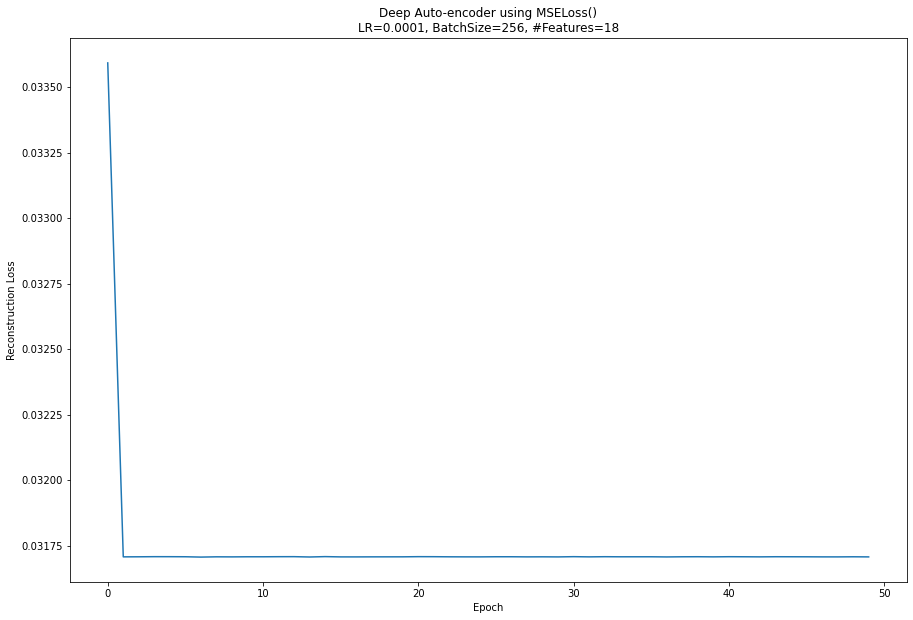

In [6]:
_, ax = plt.subplots(1,1,figsize=(15,10))
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
ax.set_title(f'Deep Auto-encoder using {loss_function}\n{hyperparam_description}')
ax.plot(train_loss)

In [7]:
# Calculate reconstruction loss for test partition (mixed flow data)
test_loss = []
net.eval()
test_tensor = torch.tensor(test_X.values.astype(np.float32))

with torch.no_grad():
    for i in range(len(test_X)):
        input = test_tensor[i].to(device=device)
        output = net(input).to(device=device)
        loss = loss_function(output, input).to(device=device)
        test_loss.append(loss.item())

Selected Attack Threshold: 0.07947563380002975
Theshold yields TPR: 0.2945, FPR: 0.0208
AUC: 0.5942


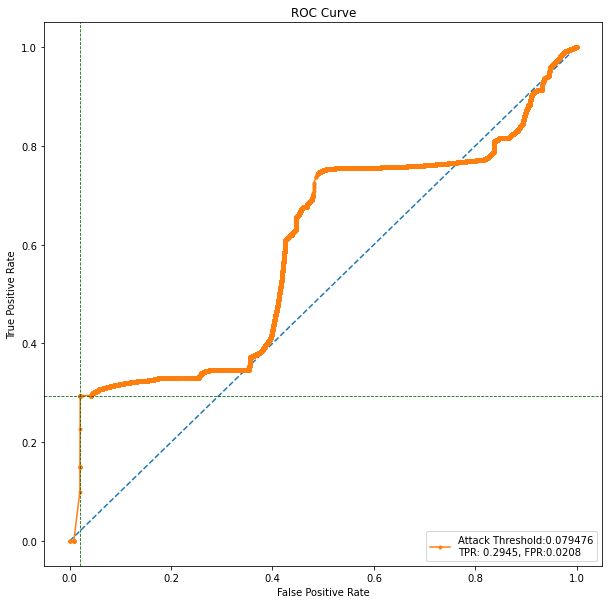

In [8]:
fpr, tpr, thresholds = roc_curve(y_true=test_y.astype(int), y_score=test_loss, pos_label=1)
ranked_thresholds = sorted(list(zip(np.abs(tpr - fpr), thresholds, tpr, fpr)), key=lambda i: i[0], reverse=True)
_, attack_threshold, threshold_tpr, threshold_fpr = ranked_thresholds[0]
print(f"Selected Attack Threshold: {attack_threshold}")
print("Theshold yields TPR: {:.4f}, FPR: {:.4f}".format(threshold_tpr, threshold_fpr))

auc = roc_auc_score(y_true=test_y.astype(int),  y_score=test_loss)
print("AUC: {:.4f}".format(auc))

plt.figure(figsize=(10, 10))
plt.plot([0,1], [0,1], linestyle="--") # plot baseline curve
plt.plot(fpr, tpr, marker=".", label="Attack Threshold:{:.6f}\nTPR: {:.4f}, FPR:{:.4f}".format(attack_threshold, threshold_tpr, threshold_fpr))
plt.axhline(y=threshold_tpr, color='darkgreen', lw=0.8, ls='--')
plt.axvline(x=threshold_fpr, color='darkgreen', lw=0.8, ls='--')
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")



              precision    recall  f1-score   support

      benign       0.64      0.98      0.78    801702
      attack       0.89      0.23      0.36    564606

    accuracy                           0.67   1366308
   macro avg       0.76      0.60      0.57   1366308
weighted avg       0.74      0.67      0.60   1366308



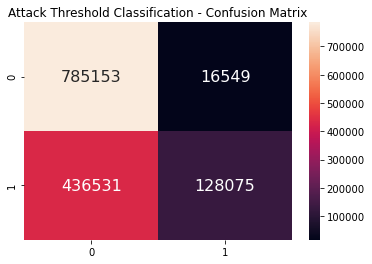

In [9]:
test_results = test_y.to_frame().astype(bool)
test_results['loss'] = pd.Series(test_loss, index=test_results.index)
test_results['is_attack_prediction'] = test_results.loss > attack_threshold

conf_matrix = confusion_matrix(test_results.is_attack, test_results.is_attack_prediction)
plt.figure()
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g')
plt.title('Attack Threshold Classification - Confusion Matrix')
print(classification_report(test_results.is_attack, test_results.is_attack_prediction, target_names=["benign", "attack"]))

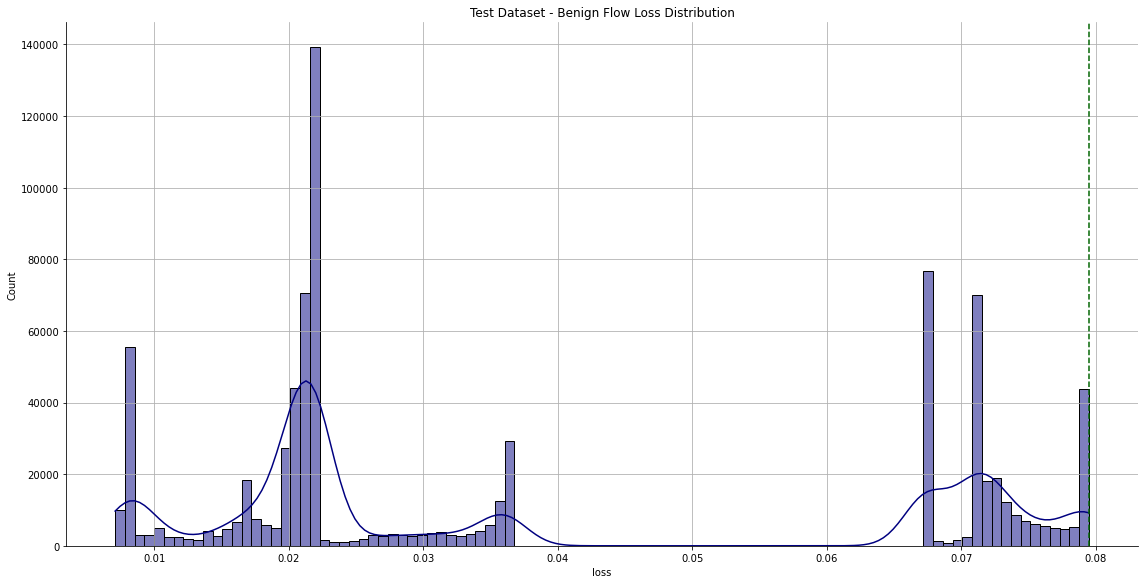

In [10]:
benign_loss = test_results[test_results['is_attack'] == False].loss
sns.displot(benign_loss, bins=100, kde=True, color='navy', height=8, aspect=2)
plt.axvline(attack_threshold, 0.0, 10, color='darkgreen', linestyle='dashed')
plt.title('Test Dataset - Benign Flow Loss Distribution')
plt.grid(True)

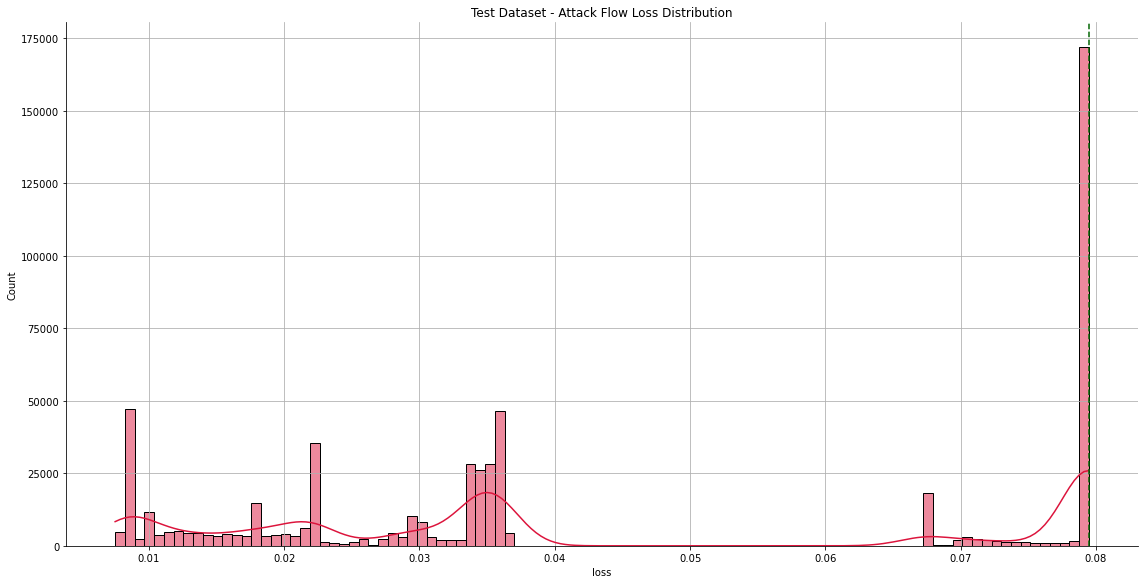

In [11]:
attack_loss = test_results[test_results['is_attack'] == True].loss
sns.displot(attack_loss, bins=100, kde=True, color='crimson', height=8, aspect=2)
plt.axvline(attack_threshold, 0.0, 10, color='darkgreen', linestyle='dashed')
plt.title('Test Dataset - Attack Flow Loss Distribution')
plt.grid(True)

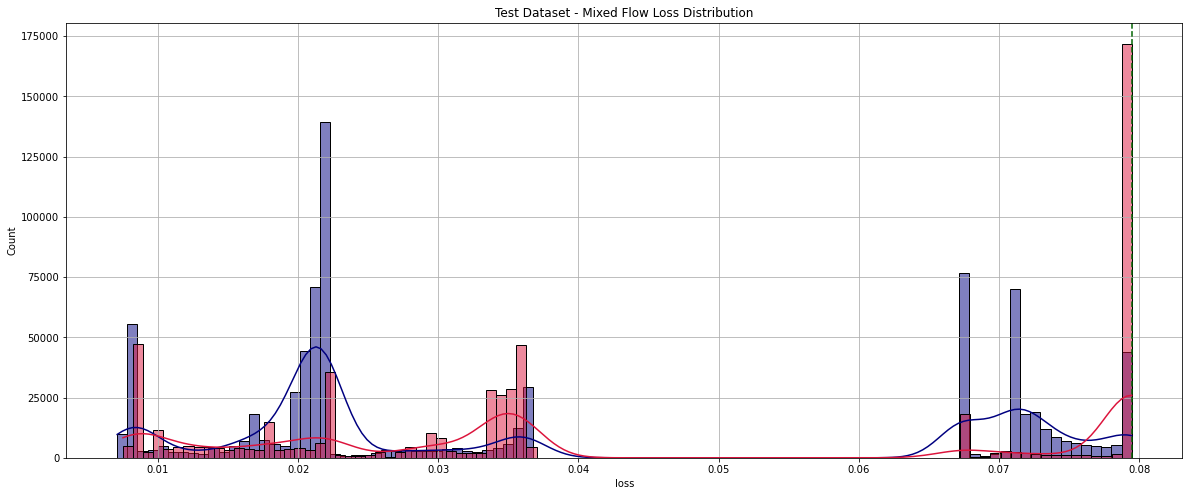

In [12]:
fig, ax = plt.subplots(figsize=(20, 8))
attack_loss = test_results[test_results['is_attack'] == True].loss
benign_loss = test_results[test_results['is_attack'] == False].loss
sns.histplot(benign_loss, ax=ax, bins=100, kde=True, color='navy', alpha=0.5)
sns.histplot(attack_loss, ax=ax, bins=100, kde=True, color='crimson', alpha=0.5)

plt.axvline(attack_threshold, 0.0, 10, color='darkgreen', linestyle='dashed')
plt.title('Test Dataset - Mixed Flow Loss Distribution')
ax.grid(True)

# Loss Density of Training-Set Post-Training - Sanity Check

In [13]:
# Calculating loss for training-set on trained model (for toubleshooting distributions)
post_train_loss = [] 
net.eval()
train_tensor = torch.tensor(train_X.values.astype(np.float32))

with torch.no_grad():
    for i in range(len(train_X)):
        input = train_tensor[i].to(device=device)
        output = net(input).to(device=device)
        loss = loss_function(output, input).to(device=device)
        post_train_loss.append(loss.item())

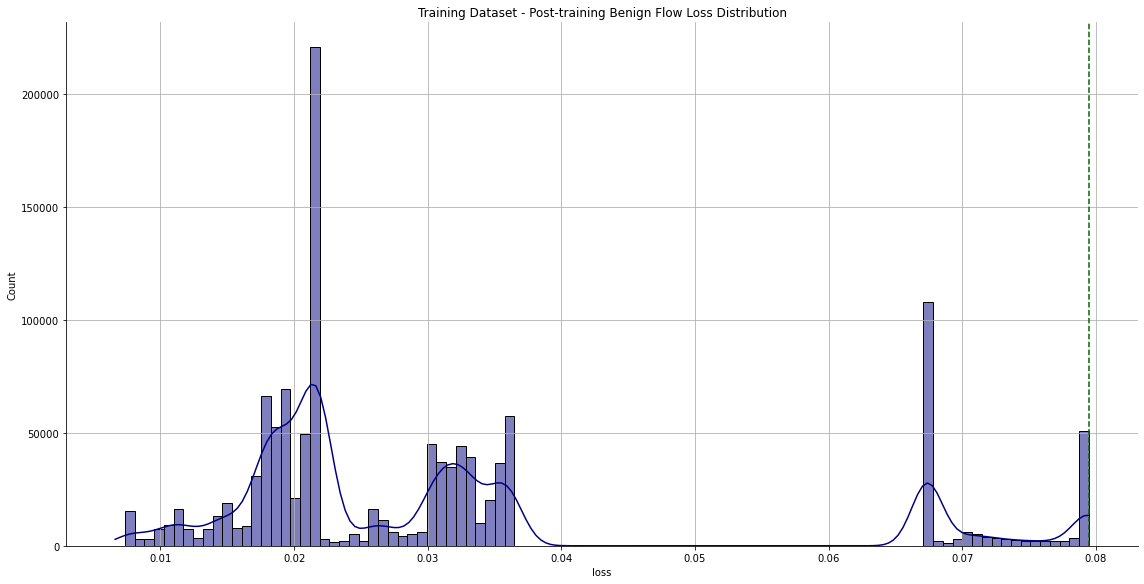

In [14]:
# Graph loss density for training set post training
post_train_results = pd.DataFrame({'is_attack': [False] * len(post_train_loss)})
post_train_results['loss'] = pd.Series(post_train_loss, index=post_train_results.index)
post_train_results['is_attack_prediction'] = post_train_results.loss > attack_threshold

sns.displot(post_train_results.loss, bins=100, kde=True, color='navy', height=8, aspect=2)
plt.axvline(attack_threshold, 0.0, 10, color='darkgreen', linestyle='dashed')
plt.title('Training Dataset - Post-training Benign Flow Loss Distribution')
plt.grid(True)